# Project 03: Gibbs Sampling (Random Algorithm)

In [2]:
import bamnostic as bs
import seqlogo
from pprint import pprint
import numpy as np

#import function for building sequence motif & idenfitying seqs matching to motif
from project03 import GibbsMotifFinder, run_parallel
import motif_ops
from utils import utils
from sequence_database import sequence_box

print("Great, everything is up to date")

Great, everything is up to date


---
## Implement Gibbs Sampler


Gibbs sampling is a MCMC approach to identify enrichments. Here we will implement a method to identify motifs from a set of regions. 

Important considerations:
- We will need to score each sequence with a PWM using the `score_kmer()` or `score_sequence()` functions
    - You will need to investigate into the help documenation and libraries to identify how best to use these functions. 
- These sites are often not strand-specific and so both scores on the negative as well as positive strand should be considered
- To select a random sequence, use `random.randint()` or `numpy.random.randint()`
- To select a new position $m$ (as defined below) use `random.choices()` or `numpy.random.choice()`  

Assumptions: 
- We know $k$ as the length of expected motif
- Each sequence contains the motif



```
GibbsMotifFinder(DNA, k-length)
    random pick of k-length sequences from each line of DNA as Motifs
    for j ← 1 to 10000 or Motifs stops changing
        i ← Random(N) where N is number of DNA entries
        PWM ← PWM constructed from all Motifs except for Motifi
        Motifi ← select position m from PWM-scored k-mers in DNAi in probabilistic fashion from score distribution
    return PFM
```

Probability of chosing position $m = \frac{A_{m}}{\sum_{l}A_{l}}$ for positions $l$ in DNAi


**Note:** I have also added a function to `motif_ops.py` that will calculate the information content of your motifs. This is useful to observe the progression of your Gibbs sampler as well as a measure of convergence. You can use this function as `IC = pfm_ic(pfm)`. You should expect a slow increase of IC until it plateaus such as in the plot below from your lecture slides:

<center><img src='figures/Gibbs_Sampling.png'/ width=600px></center>

---
# Setting up the data

This BAM file contains a subsampled set of aligned ChIP‑seq reads from a p53 immunoprecipitation experiment in human K562 cells treated with the anthracycline drug daunorubicin. The original SRA experiment SRX5865974 (run SRR9090854) reports 31.2 million Illumina NextSeq 500 ChIP‑seq read pairs from K562 wild‑type cells exposed to daunorubicin, using a p53 antibody to pull down p53‑bound chromatin fragments before library preparation and sequencing. [pmc.ncbi.nlm.nih](https://pmc.ncbi.nlm.nih.gov/articles/PMC4366240/)

### What the data represent

- Biological system: human K562 leukemia cells (Homo sapiens) treated with daunorubicin, a DNA‑damaging chemotherapeutic known to stabilize and activate p53. [pmc.ncbi.nlm.nih](https://pmc.ncbi.nlm.nih.gov/articles/PMC6561911/)
- Assay: ChIP‑seq using an antibody against p53, so reads should be enriched around genomic regions where p53 is bound after drug treatment. [pmc.ncbi.nlm.nih](https://pmc.ncbi.nlm.nih.gov/articles/PMC4526040/)
- Sequencing: Illumina NextSeq 500, with the raw run SRR9090854 corresponding to experiment SRX5865974. [github](https://github.com/ncbi/sra-tools/issues/213)
- BAM file: `SRR9090854.subsampled_5pct.bam` is a coordinate‑sorted alignment file containing ~5% of the original mapped reads, typically created by random down‑sampling the full BAM to reduce file size and speed up exploratory analyses while preserving the overall distribution of p53 binding events. [ecseq](https://www.ecseq.com/support/ngs-snippets/how-to-extract-a-list-of-specific-read-IDs-from-a-BAM-file)

### How `bamnostic` is used and what your code does

The `bamnostic` package provides a pure‑Python interface to BAM files that mirrors the `pysam` API, including an `AlignmentFile` class whose iterator yields `AlignedSegment` objects representing individual aligned reads. In your code: [bamnostic.readthedocs](https://bamnostic.readthedocs.io/en/latest/bamnostic.html)

```python
bam_path = "data/SRR9090854.subsampled_5pct.bam"

seqs = [read.seq for read in bs.AlignmentFile(bam_path)]
```

- `bs.AlignmentFile(bam_path)` opens the BAM file as an `AlignmentFile` object in binary read mode (default `'rb'`), reading the BAM header (reference contigs, read groups, etc.) and preparing a streaming interface to all aligned records. [github](https://github.com/betteridiot/bamnostic/blob/master/docs/source/quickstart.rst)
- Iterating over `AlignmentFile` (`for read in bs.AlignmentFile(...)`) returns each aligned read as a `bamnostic.AlignedSegment` object, which exposes properties analogous to SAM fields such as query name, flags, reference name, position, mapping quality, CIGAR string, and the original sequencing **sequence**. [bamnostic.readthedocs](https://bamnostic.readthedocs.io/en/latest/bamnostic.html)
- The `read.seq` attribute is the query (read) sequence string stored in the BAM, corresponding to the full read sequence (including any unaligned bases), as opposed to `query_alignment_sequence`, which would only contain the aligned portion. [bamnostic.readthedocs](https://bamnostic.readthedocs.io/en/latest/bamnostic.html)
- The list comprehension `[read.seq for read in ...]` consumes the entire BAM stream and collects the nucleotide sequences from every subsampled ChIP‑seq read into a Python list `seqs`, which can then be used for downstream tasks such as motif discovery, k‑mer analysis, or quality checks on read content. [ucdavis-bioinformatics-training.github](https://ucdavis-bioinformatics-training.github.io/2022-Feb-Introduction-To-Python-For-Bioinformatics/python/python5)

In summary, your dataset is a 5% random sample of p53‑ChIP‑seq alignments from daunorubicin‑treated K562 cells, and the `bamnostic` code opens the subsampled BAM and extracts the raw read sequences from each aligned fragment into memory as a list.

---
# Project Start

# Functions

# Our code
Check notes in each cell to see if it's what you're trying to do

In [5]:
#create the seqs array, just need to do 1 time and it will take a while. For Vic it took ~3-5 minutes.
bam_path = "data/SRR9090854.subsampled_5pct.bam"

seqs = [read.seq for read in bs.AlignmentFile(bam_path)]


In [5]:
#Check that seqs has initialized (and view some data)
pprint(seqs[0:10])

['CCTAACCCTAACCCTAACCCTAACCCTATCCAGATCG',
 'ACCCTAACCCTAACCCAAACCCTAACCCTAACAGATC',
 'CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC',
 'CTAACCCTAACCCTAACCCTAACCCTAACCCTAAC',
 'CTATCCCTAACCCTAACCCTAACCCTAACCCTAACC',
 'CGATATCCTAACCCTAACCCTAACCCTAACCCTAACC',
 'ATCTACCCTAACCCTAACCCTAACCCTAACCCTAAC',
 'TACCCCTAACCCTAACCCTAACCCTAACCCTAACCCT',
 'CCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCC',
 'CCTAACCCTAACCCTCGCGGTACCCTCAGCCGGCCCG']


In [7]:
#check that bamnostic sequences are identical to seq_box
n_rows=3083497
k=6

np_seqs, indptr = utils.io_monster(mode="")
motifs, midx = utils.fast_init(np_seqs, n_rows, indptr, k)
seq_box = sequence_box(indptr, np_seqs, midx, motifs, k)

for i in range(len(seq_box)):
    decoded_sequence = utils.decode_sequence(seq_box[i])
    if decoded_sequence != seqs[i]:
       raise ValueError("sequence mismatch")
print("no mismatch")


processed_data.npz exists, reading from path
data ready :)
no mismatch


In [36]:
#demonstrate the encoding/decoding process
x = ["GATTACA"]
print(x[0])
x = np.frombuffer("".join(x).encode(), dtype=np.uint8)
print(x)
xx = utils.encode_sequences(x, utils.init_base_encoding_map())
print(xx)
yy = utils.fast_complement(xx)
print(yy)
print(utils.decode_sequence(yy))

GATTACA
[71 65 84 84 65 67 65]
[2 0 3 3 0 1 0]
[3 2 3 0 0 3 1]
TGTAATC


In [13]:
#check that pfms are equal
motifs = seq_box.get_str_list_format_motifs()
pfm_original = motif_ops.build_pfm(motifs, length=k)
pfm_seq_box = seq_box.get_pfm()
print(np.array_equal(pfm_original, pfm_seq_box))

True


In [25]:
#check that scoring algorithms are equal
pwm = motif_ops.build_pwm(pfm_seq_box)
str_motifs = motifs[:5]
encoded_motifs = seq_box.motifs[:5]
x = [motif_ops.score_kmer(kmer, pwm) for kmer in str_motifs]
y = utils.fast_score(encoded_motifs, pwm)

print("string-pythonic method")
pprint(x)

print("fast method")
pprint(y)

string-pythonic method
[np.float64(-0.07542012565192935),
 np.float64(-0.05586938622641946),
 np.float64(-0.0628618925046327),
 np.float64(-0.028836786686813776),
 np.float64(-0.042166727390341885)]
fast method
array([-0.07542013, -0.05586939, -0.06286189, -0.02883679, -0.04216673])


In [8]:
results = GibbsMotifFinder(speed="pythonic", toprint=True)

processed_data.npz exists, reading from path
data ready :)
array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

array([[850546, 851590, 854305, 854589, 851906, 849756],
       [693515, 690207, 687418, 685104, 684035, 686204],
       [685833, 684969, 684812, 687373, 692790, 694120],
       [853603, 856731, 856962, 856431, 854766, 853417]], dtype=int32)

After 20 iterations, final motif list: ['CCTAAC', 'CCTAAC', 'CCCTAA', 'CCCTAA', 'CCTAAC', 'ATATCC', 'CTAACC', 'CCCTAA', 'CCTAAC', 'GCCGGC', 'GGTCTG', 'ATCTGT', 'GACGCA', 'CCGGGC', 'TGCTGG', 'GCTTAG', 'CAACTG', 'TTGCTT', 'GCCGGG', 'CACTGC']


In [ ]:
#runs a lot of times to check convergence - you will get a "consensus" sequence by running this. 
#if you want the pfm for seqlogo you do not need to do this

#returns the pfm
results = run_parallel(speed="fast", max_iter=1000, subsample_size=1e10, toprint=True)

---
# Driver Program
Don't change any of the code here. If you have completed the project by following the coding by contract, the following code should work.

processed_data.npz exists, reading from path
data ready :)
array([[849041, 851100, 853132, 853826, 853969, 853089, 854475, 853318,
        851424, 848825],
       [695909, 693058, 691959, 690512, 686787, 685425, 681625, 681763,
        682898, 685843],
       [686091, 683991, 682669, 682440, 684246, 690113, 689234, 692895,
        693613, 695578],
       [852456, 855348, 855737, 856719, 858495, 854870, 858163, 855521,
        855562, 853251]], dtype=int32)
beginning fast iteration
Iteration 1023, subsample 0
array([[849176, 851181, 853185, 853872, 854025, 853101, 854575, 853412,
        851525, 848925],
       [695787, 692927, 691871, 690438, 686716, 685347, 681547, 681690,
        682812, 685719],
       [685936, 683885, 682598, 682378, 684182, 690045, 689140, 692822,
        693487, 695453],
       [852598, 855504, 855843, 856809, 858574, 855004, 858235, 855573,
        855673, 853400]], dtype=int32)

algorithm did not converge :(((

After 1024 iterations, final motif list: ['AACCCTA

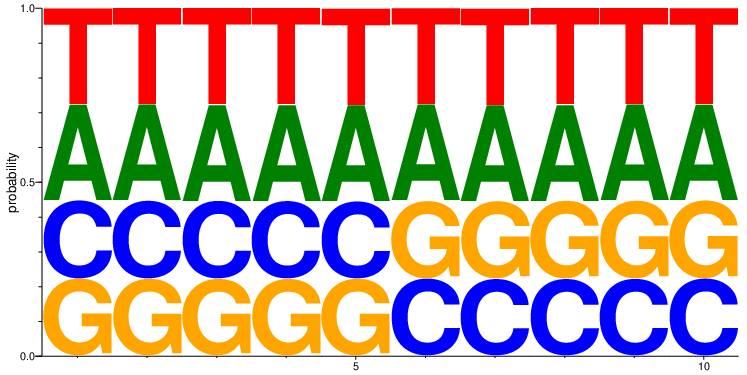

In [ ]:
#Marcus' code:
#If everything is correct, we should not need to edit this

# Run the gibbs sampler:
promoter_pfm = GibbsMotifFinder(seqs,10)

# Plot the final pfm that is generated:
ppm = seqlogo.CompletePm(pfm=promoter_pfm)
seqlogo.seqlogo(ppm, ic_scale=False, format="png", size="large", filename="test.png")